<a href="https://colab.research.google.com/github/Lupama2/IntroCUDA/blob/main/ICNPG_molecularDynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

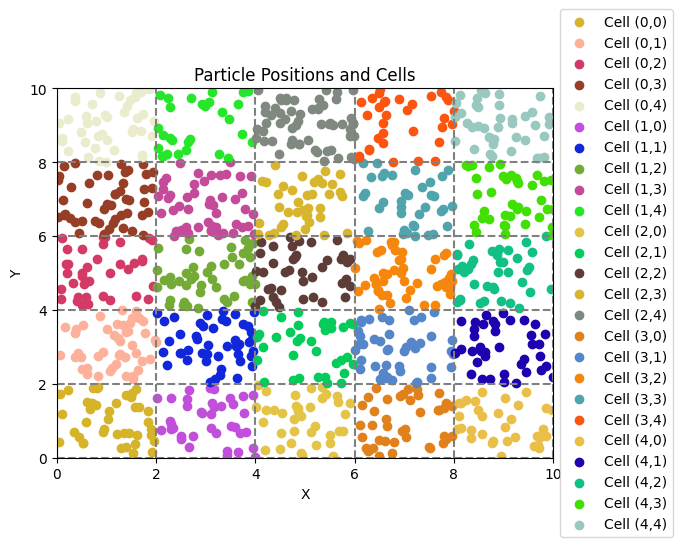

numeros de celdas desordenadas= [20  5 17 ... 10  6  3]


In [ ]:
#@title Detecccion de celdas, arrays sin ordenar por celdas
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np

def generate_particle_cells(Lx, Ly, Nx, Ny, num_particles):
    # Generate random particle positions
    particle_positions = cp.random.rand(num_particles, 2) * cp.array([Lx, Ly])

    # Calculate cell size
    cell_width = Lx / Nx
    cell_height = Ly / Ny

    # Compute the cell indices for each particle
    cell_indices = (particle_positions / cp.array([cell_width, cell_height])).astype(int)

    # Return the array of particle positions and cell indices
    return particle_positions, cell_indices

# Set the dimensions and parameters
Lx = 10.0  # Width of the space
Ly = 10.0  # Height of the space
Nx = 5     # Number of cells along x-axis
Ny = 5     # Number of cells along y-axis
num_particles = 1024  # Number of particles

# Generate particle positions and cell indices
particle_positions, cell_indices = generate_particle_cells(Lx, Ly, Nx, Ny, num_particles)

# Generate unique colors for each cell
cell_colors = np.random.rand(Nx * Ny, 3)  # Generates RGB colors for each cell

# Plot particle positions and cells
fig, ax = plt.subplots()

# Scatter plot for particle positions with cell-specific colors
for i in range(Nx):
    for j in range(Ny):
        mask = (cell_indices[:, 0] == i) & (cell_indices[:, 1] == j)
        ax.scatter(cp.asnumpy(particle_positions[mask, 0]), cp.asnumpy(particle_positions[mask, 1]),
                   color=cell_colors[i*Ny + j], label=f'Cell ({i},{j})')

# Grid lines for cells
for i in range(Nx+1):
    ax.axvline(i * Lx / Nx, color='gray', linestyle='dashed')
for j in range(Ny+1):
    ax.axhline(j * Ly / Ny, color='gray', linestyle='dashed')

# Set plot limits and labels
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Particle Positions and Cells')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

cell_number = cell_indices[:, 0] * Ny + cell_indices[:, 1]
print("numeros de celdas desordenadas=", cell_number)

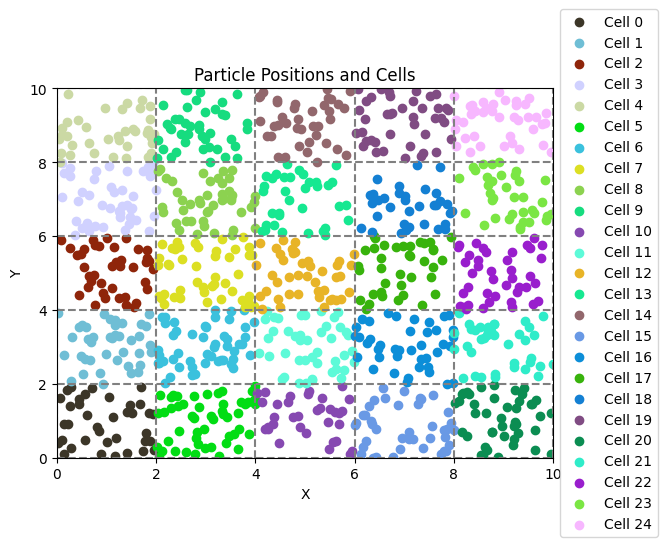

numeros de celdas ordenadas= [ 0  0  0 ... 24 24 24]


In [ ]:
#@title Detecccion de celdas, arrays ordenado por celdas
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np

def generate_particle_cells(Lx, Ly, Nx, Ny, num_particles):
    # Generate random particle positions
    particle_positions = cp.random.rand(num_particles, 2) * cp.array([Lx, Ly])

    # Calculate cell size
    cell_width = Lx / Nx
    cell_height = Ly / Ny

    # Compute the cell indices for each particle
    cell_indices = (particle_positions / cp.array([cell_width, cell_height])).astype(int)

    # Calculate the cell number for each particle
    cell_number = cell_indices[:, 0] * Ny + cell_indices[:, 1]

    # Sort the particle positions by cell number
    sorted_indices = cp.argsort(cell_number)
    sorted_positions = particle_positions[sorted_indices]
    sorted_cell_number = cell_number[sorted_indices]

    # Return the sorted particle positions and cell number
    return sorted_positions, sorted_cell_number

# Set the dimensions and parameters
Lx = 10.0  # Width of the space
Ly = 10.0  # Height of the space
Nx = 5     # Number of cells along x-axis
Ny = 5     # Number of cells along y-axis
num_particles = 1024  # Number of particles

# Generate particle positions and cell number
particle_positions, cell_number = generate_particle_cells(Lx, Ly, Nx, Ny, num_particles)

# Generate new arrays xo and yo sorted by cell number
xo = cp.asnumpy(particle_positions[:, 0])
yo = cp.asnumpy(particle_positions[:, 1])
hcell_number = cp.asnumpy(cell_number)

# Generate unique colors for each cell
cell_colors = np.random.rand(Nx * Ny, 3)  # Generates RGB colors for each cell

# Plot particle positions and cells
fig, ax = plt.subplots()

# Scatter plot for particle positions with cell-specific colors
for i in range(Nx):
    for j in range(Ny):
        mask = (hcell_number == i * Ny + j)
        hx, hy = xo[mask],yo[mask]
        ax.scatter(hx, hy, color=cell_colors[i * Ny + j], label=f'Cell {i*Ny+j}')

# Grid lines for cells
for i in range(Nx + 1):
    ax.axvline(i * Lx / Nx, color='gray', linestyle='dashed')
for j in range(Ny + 1):
    ax.axhline(j * Ly / Ny, color='gray', linestyle='dashed')

# Set plot limits and labels
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Particle Positions and Cells')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# Show the plot
plt.show()

print("numeros de celdas ordenadas=", hcell_number)

Ahora podemos escribir un kernel, asignando cada hilo a una particula, y cada bloque a una celda. Los hilos de un bloque se dedican a calcular las interacciones de sus particulas con las de su misma celda y con las de celdas vecinas. Antes de proseguir, hay que decidir las condiciones de contorno, para definir bien que quiere decir celda vecina cuando la celda esta pegada al borde.


El kernel de nbody con interacciones de largo alcance puede ser adaptado si en vez de recorrer todas las particulas, recorremos solo las de celdas vecinas.
